# Overview

[Note: for any compatibility issues, I am running this notebook on python2.7]

As I try to learn as much as I can about data science by working with publicly available data sets and the examples of others, the question of which set of data to analyze, given their relative ubiquity on the web nowadays, presented itself rather obstinantly to me.

So I thought of the current situation I find myself in, living abroad in the eternal city, Rome. If someone asks me what I like most of Rome, I must give pause and think of its infinite beautiful facades. But if someone asks me what I like least, I can answer quite easily: traffic. Rather than complaining, as one is wont to do in (southern(ish)) Italy, I decided that perhaps I could use my nascent learned data science skills to see if I can't learn something useful about Rome's traffic catastrophe and find patterns that only statistical methods on large data sets can find.

Sure enough, even Rome has certain public data free for the public to play with. So I obtained data on traffic accidents and traffic incidences involving pedestrians from Rome's public data repo at

http://dati.comune.roma.it/download

(all data is in Italian, of course) and did the most basic of analyses.

First we'll have a look at the data involving pedestrians ('pedoni') as the data set is smaller. Next we will have a look at the general traffic incidences, of which there are many more case with a plethora of descriptive data attached to each incidence.

In [56]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import json, re, textwrap, patsy, datetime, geoplotlib
from IPython.display import Image
from unidecode import unidecode
from sklearn import cross_validation, metrics, linear_model, svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors.kde import KernelDensity

# Pedoni data

Here I took a much smaller data set that only involved pedestrians (and some sort of vehicle). This set was not as extensive as the general traffic incidence set below, but allowed me to warm up on reading in the JSON data Rome provided and look at the distribution of incidences as a function of age and gender, and to see what percentage of (reported) incidences result in a pedestrian death.



First we simply write a function to read in the data and clean it up a little bit so that Pandas can successfully parse the data.

In [96]:
def load_pedoni_data(json_file):
    with open(json_file, 'r') as filename:
        data = filename.readlines()

    # Overwrite first line with just a [    
    data[0] = '[\n'
    data[-1] = ']\n'

    with open('edited_json_pedoni.json', 'w') as filename:
        filename.writelines(data)

    return(pd.read_json("edited_json_pedoni.json", orient='records'))

pedoni = load_pedoni_data('json_pedoni_01.7.2014_31.12.2014.json')
pedoni.columns.values

array([u'AANascita', u'Deceduto', u'DecedutoDopo', u'IDProtocollo',
       u'Sesso', u'TipoLesione', u'TipoPersona'], dtype=object)

I want to look at the incidences as a function of age, since they provide the birth year in the data. I get rid of birth years of '0' (nonsensical data) then create a new column that gives the age of the victim.

In [97]:
pedoni = pedoni.query('AANascita != 0')
pedoni['age'] = pedoni.apply(lambda row:2015-row['AANascita'], axis=1)

Now I'll plot the distribution of ages and gender in the incidences, comparing each distribution for incidences where the pedestrian survived versus where a fatality resulted (the 'Deceduto' feature indicates the victim died immediately as a result of the incident). We can also plot the number of incidences without fatalities versus those with.

Total number of cases with fatalities: 17


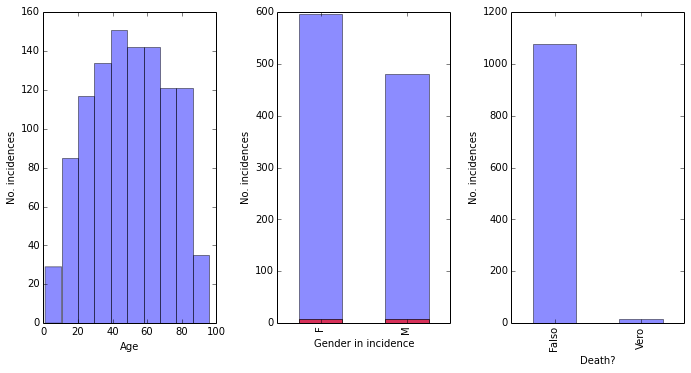

In [98]:
f, a = plt.subplots(1,3)
f.tight_layout()
f.set_size_inches(10,5)

width=0.35
index=np.arange(2)

a[0].hist(pedoni[pedoni.Deceduto == 'Falso'].age, color='b', alpha=0.45) # no fatality
# There is a problem with making a histogram of these data- perhaps not enough points
#a[0].hist(pedoni[pedoni.Deceduto == 'Vero'].age, color='r', alpha=0.65) # fatality
a[0].set_xlabel('Age')
a[0].set_ylabel('No. incidences')

plt.subplot2grid((1,3),(0,1))
pedoni[pedoni.Deceduto == 'Falso'].Sesso.value_counts().plot(kind='bar', color='b', alpha = 0.45) # no fatality
pedoni[pedoni.Deceduto == 'Vero'].Sesso.value_counts().plot(kind='bar', color='r', alpha = 0.65) # death resulted
plt.xlabel('Gender in incidence')
plt.ylabel('No. incidences')

plt.subplot2grid((1,3),(0,2))
pedoni.Deceduto.value_counts().plot(kind='bar', alpha = 0.45)
plt.xlabel('Death?')
plt.ylabel('No. incidences')

print('Total number of cases with fatalities: {0}'.format(len(pedoni[pedoni.Deceduto == 'Vero'])))

You can see in the distribution of the ages that the number of incidences with no fatalies far outweighs those with fatalities. So it isn't too useful to look at. However, in the traffic accidents below we can look at a more useful quantity- whether or not death *or* injury occurs, as this (macabre, yes) feature gives better statistics (and is still useful to look at).

# Incidenti data

We can proceed to analyze the traffic incident ('incidenti' in Italian) data, though we have to clean up the data a bit more thoroughly for processing, which needs to be done carefully, as the JSON files are much larger for these incidences (approximately 15K records for every 6 months of data). We examine one 6 month period in particular, July-December 2014 (the same period was used for the pedoni data above).

There are a few things we need to do first - in Python, so all processes are reproducible. The JSON file provided by the Roma public data utility has a few things we need to clear up- I remove the initial line with an unnecessary label of the file name and make sure brackets and commas are properly arranged so as to be read by pd.read_json. I also have to decode the text from 'latin' and then use a handy utility called 'unidecode' to reincode each record in the JSON file such that the accents (ubiquitous in Italian) are replaced with their nearest unaccented equivalent. 

I also remove one particular field, 'DaSpecificare' because it is a qualitative descriptive field (a short phrase describing the incident) that I don't expect to be of use in any analysis (it can't possibly be turned into a categorical variable) and because certain descriptions involved quotes in their descriptions (much like my current university isn't called La Sapienza, but rather Università di Roma, 'La Sapienza') that muck with the expected JSON format. So I just remove that field completely and write to a new file.

I also do a few other things that I have now lumped into this function "clean_incidenti_data", including replacing commas with decimals to match with the locale on my machine for converting to floats

In [2]:
# for now pd.read_json seems to get angry if I load to many lines in, so only load 9000 for now 
# (just to get an idea of what to do- reuse same code with data set)
def load_incidenti_data(json_file):
    with open(json_file, 'r') as filename:
        # for now pd.read_json seems to get angry if I load to many lines in, so only load 9000 for now 
        # (just to get an idea of what to do- reuse same code with data set)
        # (I really don't understand this error: 
        # ValueError: Key name of object must be 'string' when decoding 'object'
        # and the internet is not helping)
        data = [next(filename) for x in xrange(9000)]
        #data = filename.readlines()

    for num, line in enumerate(data,0):
        if num == 0:
            data[num] = '[\n'
        # must remove comma at end of last line
        elif num == len(data)-2 and len(data) > 2:
            # need to include a (mac?) symbol \r that comes with each new line
            tmp = re.sub("\"DaSpecificare.*?.\", ","",re.sub(",\r$","",line))
            # In the future I should look for a BOM to detect encoding automatically
            data[num] = unidecode(tmp.decode('latin'))
        elif num == len(data)-1:
            data[num] = ']\n'
        else:
            tmp = re.sub("\"DaSpecificare.*?.\", ","",line)
            data[num] = unidecode(tmp.decode('latin'))

    with open('edited_json_incidenti.json', 'w') as filename:
        filename.writelines(data)
    
    return(pd.read_json('edited_json_incidenti.json', orient='records'))

# We are overwriting the dataframe in each of the steps below, so we turn this warning off
pd.options.mode.chained_assignment = None  # default='warn'
def clean_incidenti_data(dataframe):
    dataframe['harmed'] = dataframe.apply(lambda row: 1 if row['NUM_MORTI']+row['NUM_FERITI'] > 0 else 0, axis=1)
    dataframe.drop(['NUM_MORTI','NUM_FERITI'], axis=1, inplace=True)

    # Drop terms that don't match the time format I want
    dataframe['time_match'] = dataframe.apply(lambda row: re.search(' \d{1,2}\.\d{2}',row['DataOraIncidente']) is not None, axis=1)
    dataframe = dataframe.query('time_match')

    # Gives the time (of day) as a time_struct 
    dataframe['time'] = dataframe.apply(lambda row: datetime.datetime.strptime(re.search(' \d{1,2}\.\d{2}\.\d{2}',row['DataOraIncidente']).group().lstrip(), '%H.%M.%S'), axis=1)
    dataframe.drop('time_match', inplace=True, axis=1)

    # Finally, convert European style decimals to US-style, since my locale is not European
    # A bit of a workaround, but it functions
    dataframe['Latitudine'] = dataframe.apply(lambda row: row['Latitudine'].replace(',','.'), axis=1)
    dataframe['Longitudine'] = dataframe.apply(lambda row: row['Longitudine'].replace(',','.'), axis=1)
    dataframe.Latitudine = dataframe.Latitudine.astype(float)
    dataframe.Longitudine = dataframe.Longitudine.astype(float)
    return(dataframe)

Now before doing anything else, we set aside 30% of the data, randomly chosen, as test data. We take what is leftover as training data and clean it (which amounts to renaming some rows and converting European style decimals to American style for greater ease of the use of float).

In [3]:
incidenti = load_incidenti_data('json_incidenti_01.7.2014_31.12.2014.json')

test = incidenti.sample(frac=0.3, replace=False)
test = clean_incidenti_data(test)
train = incidenti.loc[~incidenti.index.isin(test.index)]
train = clean_incidenti_data(train)

train.columns.values

array([u'CONFERMATO', u'Chilometrica', u'CondizioneAtmosferica',
       u'DataOraIncidente', u'FondoStradale', u'Gruppo', u'ID',
       u'Illuminazione', u'Latitudine', u'Localizzazione1',
       u'Localizzazione2', u'Longitudine', u'NUM_ILLESI', u'NUM_RISERVATA',
       u'NaturaIncidente', u'ParticolaritaStrade', u'Pavimentazione',
       u'Segnaletica', u'Strada02', u'Strada1', u'Strada2', u'TipoStrada',
       u'Traffico', u'Visibilita', 'harmed', 'time'], dtype=object)

## Visualizing categorical data

Let's look at distributions of events with people injured versus those without injury (or death). I've taken only the features that seem to have a reasonable number of categorical choices that might be used for fitting later.

In [4]:
# These look like interesting features that we will investigate below
features=['CondizioneAtmosferica','FondoStradale','Illuminazione','Localizzazione1','Pavimentazione','Segnaletica','TipoStrada','Traffico','Visibilita']

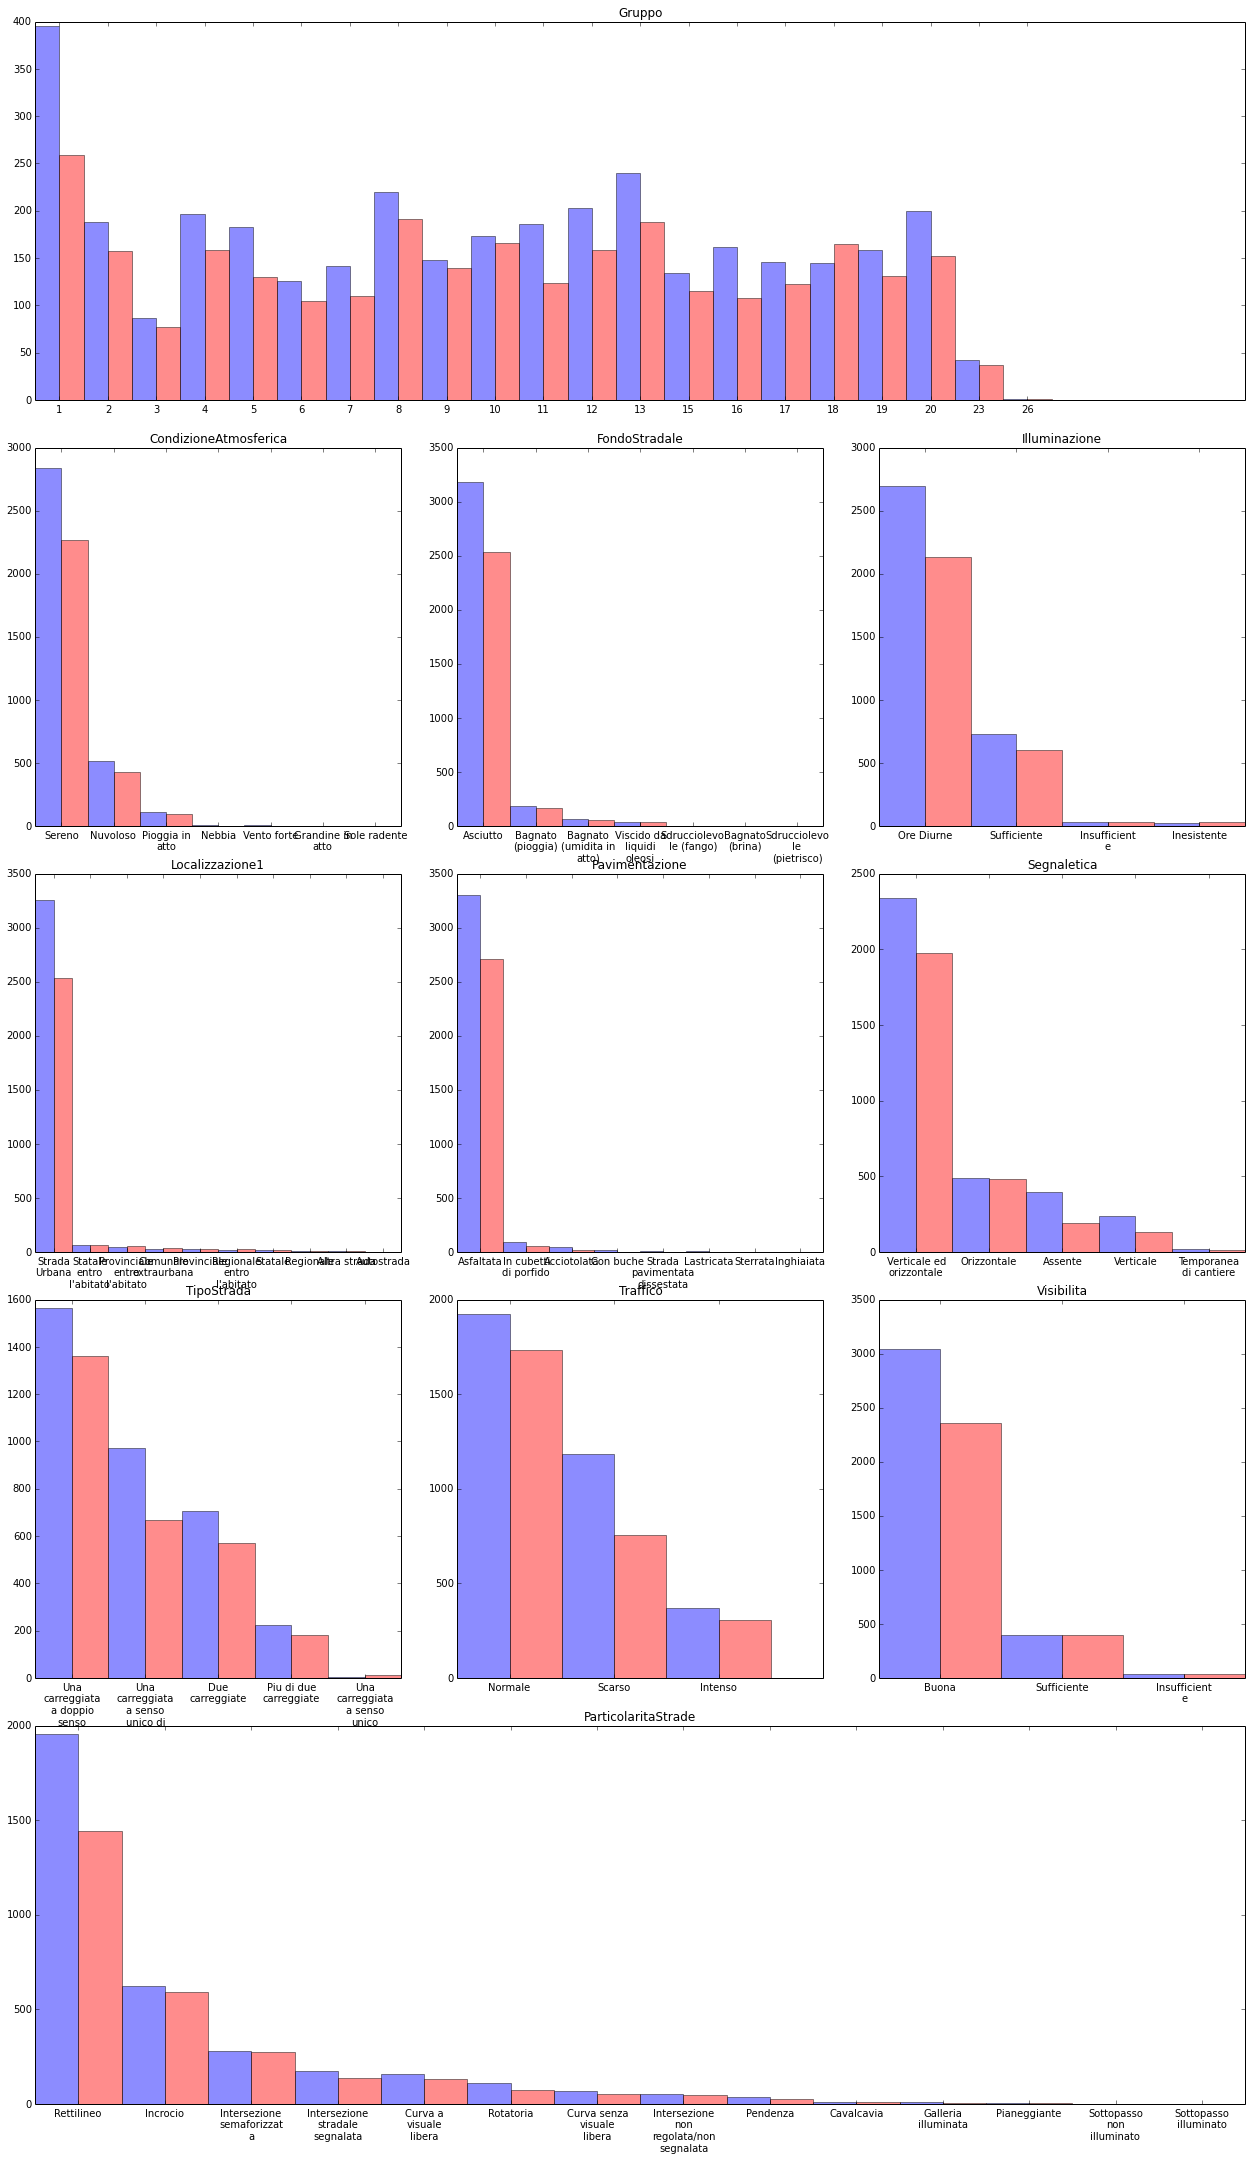

In [5]:
fig = plt.figure(dpi=1600)
f, a = plt.subplots(len(features)/3+2,3,figsize=(18,30))
f.tight_layout(pad=3)

# One with a lot of options, don't exactly know what 'Group' is, but we can look at it as a variable
#Gruppo
plt.subplot2grid((len(features)/3+2,3),(0,0),colspan=3)
valsNoHarm = train[train.harmed == 0]['Gruppo'].value_counts().sort_index()
valsHarm = train[train.harmed > 0]['Gruppo'].value_counts().sort_index()
keys1 = valsNoHarm.keys()
keys2 = valsHarm.keys()
ind = np.arange(len(keys1))
ind2 = np.arange(len(keys2))
width=.5
plt.bar(ind,np.asarray(valsNoHarm),width, color='b', alpha=0.45)
plt.bar(ind2+width,np.asarray(valsHarm),width, color='r', alpha=0.45)
plt.xticks(ind+width,keys1)
plt.title('Gruppo')

for i,feature in enumerate(features,0):
    valsNoHarm = train[train.harmed == 0][feature].value_counts()
    valsHarm = train[train.harmed > 0][feature].value_counts()
    keys = valsNoHarm.keys()
    keys2 = valsHarm.keys()
    keys = [textwrap.fill(text,12) for text in keys]
    ind = np.arange(len(keys))
    ind2 = np.arange(len(keys2))
    width=.5
    a[i/3+1,i%3].bar(ind,np.asarray(valsNoHarm),width, color='b', alpha=0.45)
    a[i/3+1,i%3].bar(ind2+width,np.asarray(valsHarm),width, color='r', alpha=0.45)
    a[i/3+1,i%3].set_xticks(ind+width)
    a[i/3+1,i%3].set_xticklabels(keys)
    a[i/3+1,i%3].set_title(feature)

# One with a lot of options, span last row
#ParticolaritaStrade
plt.subplot2grid((len(features)/3+2,3),(4,0),colspan=3)
valsNoHarm = train[train.harmed == 0]['ParticolaritaStrade'].value_counts()
valsHarm = train[train.harmed > 0]['ParticolaritaStrade'].value_counts()
keys = valsNoHarm.keys()
keys2 = valsHarm.keys()
keys = [textwrap.fill(text,12) for text in keys]
ind = np.arange(len(keys))
ind2 = np.arange(len(keys2))
width=.5
plt.bar(ind,np.asarray(valsNoHarm),width, color='b', alpha=0.45)
plt.bar(ind2+width,np.asarray(valsHarm),width, color='r', alpha=0.45)
plt.xticks(ind+width,keys)
plt.title('ParticolaritaStrade')

# Will fix padding of plots later

There don't seem to be any obvious deviations of incidences with harm done to those involved versus those without. For now we move on since there is no smoking gun discriminant between the two data sets in these categorical data.

One thing to note is that one must be careful with looking at just the raw numbers in these distributions- all I was really looking for was shape discrimination between the 'signal' events (incidents that had injury) and 'background' events, to use particle physics parlance. The raw (not percentage) can also be used to clue me in on what features will actually be useful for a fit- for example, if only a few 'signal' events occur in a particular category of one of the features with virtually no 'background' events, this is not all that useful for building a model from, since a decision tree that might be trained to think "is in this category of this feature -> predict signal" will apply this criterion extremely rarely (the non-law of low statistics).

## Visualizing geographical data

We will look at latitude, longitude, and time features separately (they more warrant scatters and a histogram, respecively). We actually cut off the plot here because most of it is empty space- there are some outlier accidents under jurisdiction of Rome that should be removed from the data from reasonable analysis of the city proper.

Let's learn to use geoplotlib while we are at it, and see what roads these clearly defined lines and arcs of accidents corrispond to. Geoplotlib, it turns out, is the ish.

In [6]:
# Let's make a kde plot of latitude and longitude
from geoplotlib.utils import BoundingBox


coordsNoHarm = train[train.harmed == 0][['Latitudine','Longitudine']]
coordsNoHarm.columns = ['lat','lon']
dataNoHarm = geoplotlib.utils.DataAccessObject(coordsNoHarm)
# this cmap colorscheme courtesy the suggestion of Alex Mendez
geoplotlib.tiles_provider('positron')
geoplotlib.kde(dataNoHarm, bw=3, cut_below=1e-3, cmap='GnBu')
geoplotlib.set_bbox(BoundingBox(north=41.99,west=12.50,south=41.75,east=12.59))
geoplotlib.inline(800)
geoplotlib.savefig('noHarmedHeatMap')

coordsHarm = train[train.harmed > 0][['Latitudine','Longitudine']]
coordsHarm.columns = ['lat','lon']
dataHarm = geoplotlib.utils.DataAccessObject(coordsHarm)
geoplotlib.tiles_provider('positron')
geoplotlib.kde(dataHarm, bw=3, cut_below=1e-3, cmap='OrRd')
geoplotlib.set_bbox(BoundingBox(north=41.99,west=12.50,south=41.75,east=12.59))
geoplotlib.inline(800)
geoplotlib.savefig('harmedHeatMap')


# I don't use geoplotlib.show() so that the geoplotlib worldmap doesn't show up in a separate window each time
Image('noHarmedHeatMap')
Image('HarmedHeatMap')

('smallest non-zero count', 1.9901719039787654e-09)
('max count:', 0.36632289130086165)


('smallest non-zero count', 1.9901719039787654e-09)
('max count:', 0.38908070942282513)


In [8]:
# Same thing but zoomed on the center
coordsHarm = train[train.harmed > 0][['Latitudine','Longitudine']]
coordsHarm.columns = ['lat','lon']
dataHarm = geoplotlib.utils.DataAccessObject(coordsHarm)
geoplotlib.tiles_provider('positron')
geoplotlib.kde(dataHarm, bw=3, cut_below=1e-6, cmap='OrRd')
geoplotlib.set_bbox(BoundingBox(north=41.92,west=12.535,south=41.83,east=12.55))
geoplotlib.inline(1200)
geoplotlib.savefig('harmedHeatMapZoomed')

Image('harmedHeatMapZoomed')

# To do: if we could compute a difference heat map that compared incidences with/out injuries 
# and showed their *relative* occurrences, that might be neat

('smallest non-zero count', 8.8840472701097864e-08)
('max count:', 0.172559673018083)


You can see that the major radial roads of Rome contain most of the incidences- not too much surprising there. Another interesting but not surprising pattern is the ring of accidents that traces the river through Rome- the Lungotevere ('Along the Tiber') road is terribly managed with few lane markings and is often a speedway for the reckless, so this doesn't surprise me to find accidents there (these value statements made in my judgement).

I would also point out that the outlier points away from the center are probably not anything to do with hotspots and randomly isolated points of traffic contention, but probably rather [strange administrative bounds of Rome](https://goo.gl/maps/zipoNC2ondM2) that keep these locations within the Rome police jurisdiction.

## Visualizing temporal data

We can also plot the incidences as a function of the time of day. Below we construct histograms for the two categories (no harm done in incident versus incidences with injury and/or death). 

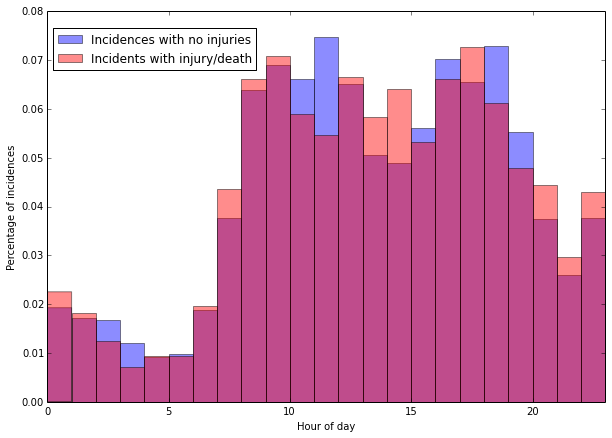

In [9]:
f, a = plt.subplots()
f.set_size_inches(10,7)
unharmed_bins = np.asarray(train[train.harmed == 0].time.groupby(train.time.dt.hour).count())
harmed_bins = np.asarray(train[train.harmed > 0].time.groupby(train.time.dt.hour).count())
ind = np.arange(24)
width = 1
noharmplt = a.hist(np.asarray(train[train.harmed == 0].time.dt.hour), bins=np.arange(24), normed=1, color='b', alpha=0.45)
harmplt = a.hist(np.asarray(train[train.harmed > 0].time.dt.hour), bins=np.arange(24), normed=1, color='r', alpha=0.45)
a.set_xlim(0,23)
a.set_xlabel('Hour of day')
a.set_ylabel('Percentage of incidences')
a.legend(('Incidences with no injuries','Incidents with injury/death'), loc=(.01,.85))

So one 'cool' thing we can see here ('cool' in the sense of patterns that we are familiar with being manifest, not in the sense of injury or death ocurring) is the bimodal peak in incidences at rush hour- around 9-10 AM and 4-6 PM (it's Rome, with Italian work hours, OK?). Unfortunately for discriminating against the two data sets it seems incidences involving death or injury do not follow any particularly distinct pattern from those that do not.

However, it is interesting to note that the only places where the number of incidences that result in injuries outnumber those that do not, at least in this data set, are late at night, between either 10-11 PM or 1-2 AM.

# Fitting the data

Now at this point I was thinking that this data looked a bit like the [Titanic Kaggle competition](http://nbviewer.ipython.org/github/agconti/kaggle-titanic/blob/master/Titanic.ipynb) data I had seen a little while ago- in the sense that there were many categorical features predicting, rather morbidly yet again, the likelihood of death in that particular row of data (in that case representing a passenger on the Titanic). 

So I will try something naive here that emulates that strategy. This means a logistic regression and then a fit based upon the more complicated (but still ridiculously easy to call here) support 
vector machine (SVM) supervised learning. Actually, because so much of the data is categorical, plain old decision trees (and hence random forests) are probably a good bet. Let's try random forest first. We need to convert some of the cateogorical pieces into numbers, so we do that with a formula and dmatrices from the patsy library:

In [4]:
# Center of Rome: (41.898713,12.475306)
#formula = 'harmed ~ C(Gruppo, Poly) + C(CondizioneAtmosferica) + C(FondoStradale) + C(Illuminazione) + C(Localizzazione1) + C(Pavimentazione) + C(Segnaletica) + C(TipoStrada) + C(Traffico) + C(Visibilita) + time.dt.hour + Latitudine + Longitudine'
train['distance'] = train.apply(lambda row: (row['Latitudine']-41.898713)**2 + (row['Longitudine']-12.475306)**2, axis=1)
test['distance'] = test.apply(lambda row: (row['Latitudine']-41.898713)**2 + (row['Longitudine']-12.475306)**2, axis=1)

In [12]:
# -1 takes away the intercept
# we need to be intelligent about how we use this formula: what physical intuition can we base it on?
# The simplest thing would be to measure distance from the center and combine that with the hour of the day
# The 'Traffico' column gives me some weird bugs below so I remove it for now
formula = 'harmed ~ C(Gruppo, Poly) + C(Illuminazione, Poly) + C(Localizzazione1, Poly) + C(Pavimentazione, Poly) + C(Segnaletica, Poly) + C(TipoStrada, Poly) + C(Visibilita, Poly) + distance + time.dt.hour - 1'

# Construct the matrices that convert categorical data into numerical values
ytrain, xtrain = patsy.dmatrices(formula, data=train, return_type='dataframe')
ytrain = np.asarray(ytrain).ravel()


# for uniformity between train and test sets, we drop some of the features that have Polynomial coefficients
# above a certain threshold. Because some types of values for each feature don't make it into the test set,
# we have to drop these to achieve uniformity across the xtrain and xtest sets.
# The way we will do this is to essentially check (via regex) if the polynomial fit goes higher than cubic, 
# when patsy uses ^n to indicate the order of the polynomial coefficient
for feature in xtrain.columns:
    if re.search('Poly\)\^\d{1,2}',feature) is not None:
        xtrain.drop(feature, axis=1, inplace=True)
        
#######################
# Same with test data
#######################
ytest, xtest = patsy.dmatrices(formula, data=test, return_type='dataframe')
ytest = np.asarray(ytest).ravel()

# See comments above about dropping certain columns
for feature in xtest.columns:
    if re.search('Poly\)\^\d{1,2}',feature) is not None:
        xtest.drop(feature, axis=1, inplace=True)

## With Random Forest

dmatrices is probably an intelligent way to return a set of data that has had categorical data turned into numbers suitable for RF.

I am just going to add things together. In the future, though, perhaps something closer to a likelihood profile (a generalization of a xi^2 profile) will be more appropriate, but this is not necessarily sensical for a random forest. 

Essentially this formula converts all the categorical options into one sum number.This coarse-grains the process a bit, and doesn't take into account any specific expectations we have of the traffic patterns. I might want to include the time and positions (via (lat,long)) in a different manner later, but for now let's just do something stupid and get a fit working.

In [83]:
# Construct the actual fit; we can vary the number of trees in the forest
# (the number of estimators) later to see how much the accuracy changes
# using the learning_curve function from sklearn
clf = RandomForestClassifier(n_jobs=-1, n_estimators=500)
clf.fit(xtrain, ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Now we'd like to do the right thing and properly train this using cross-validation; the simplest version of this does a k-fold splitting of the training data (which already was only 70% of the original data) into new training and testing bits with sizes x and (1-x) of the training set k times, 0 < x < 1.

For example, if x = 0.8 and k = 4, we split the training data set further 80% into training, 20% into testing 4 different times, each time with different 80/20 partitions of the data. This reduces overfitting and bias from a particular selection of training data.

In [84]:
# cv = 'cross-validations' = 'no. of k-foldings to do' in the language I used above
scores_train = cross_validation.cross_val_score(clf, xtrain, ytrain, cv=10)
print scores_train
# With 68% CLs on the accuracy
print 'Average accuracy on cross-validated training set: %0.3f ± %0.3f' % (scores_train.mean(),scores_train.std())

[ 0.5366242   0.49522293  0.56369427  0.55661882  0.51834131  0.53269537
  0.52791069  0.53110048  0.54704944  0.50958466]
Average accuracy on cross-validated training set: 0.532 ± 0.020


Do the same thing on the test data. We also grab the predictions for the test data as a probability that the event in question results in injury.

In [85]:
predictions_cv = cross_validation.cross_val_predict(clf, xtest, ytest, cv=10)
predictions = clf.predict_proba(xtest) 

In [86]:
score_test = metrics.accuracy_score(ytest, predictions_cv)
print 'Accuracy on test data: %0.3f' % score_test

Accuracy on test data: 0.528


Not all that impressive. It's barely better than tossing a coin to decide if an incident will have injuries occur! We can see how badly this fit does by also plotting the ROC curve and comparing it to the 50% false positive rate (fpr)/ true positive rate (tpr):

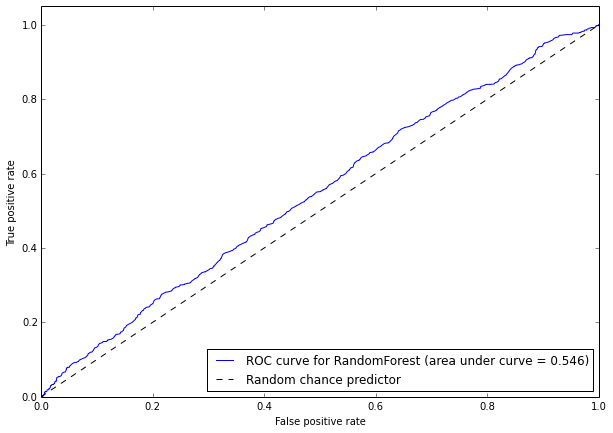

In [88]:
fpr_rf, tpr_rf, thresholds = metrics.roc_curve(ytest, predictions[:,1])
roc_auc_rf = metrics.auc(fpr_rf,tpr_rf)
f, a = plt.subplots()
f.set_size_inches(10,7)

a.plot(fpr_rf, tpr_rf, label='ROC curve for RandomForest (area under curve = %0.3f)' % roc_auc_rf)
# The 50/50 fpr/tpr line
a.plot([0,1],[0,1],'k--', label='Random chance predictor')
a.set_xlim(0.0,1.0)
a.set_ylim(0.0,1.05)
a.set_xlabel('False positive rate')
a.set_ylabel('True positive rate')
a.legend(loc='lower right')

It's horrible- one might even say 'pathetic'. So we try another model!

Remember that the overall goal of this was to identify the parameter space of the features provided with heightened probability of that incident resulting in injury or death. Then in principle we could report this finding to the city of Rome and, if they could ever get it together, they could reduce such incidences by adjusting, if possible, those parameters.

## With Logit regression

Let's try this special case of a SVM and see if drawing a line through the data to decide on the outcome is any better.

In [72]:
# Toying with C value for now to understand its effect
clf = linear_model.LogisticRegression(C=1)
clf.fit(xtrain,ytrain)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [73]:
predictions_to_be_scored = clf.predict(xtest)
predictions = clf.predict_proba(xtest)

In [74]:
score_test = metrics.accuracy_score(ytest, predictions_to_be_scored)
print 'Accuracy on test data: %0.3f' % score_test

Accuracy on test data: 0.554


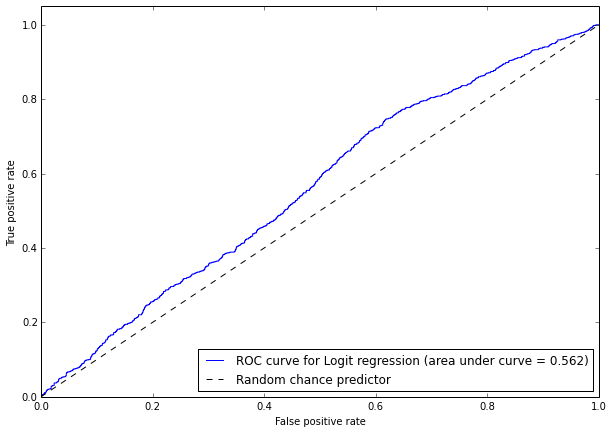

In [76]:
fpr_logit, tpr_logit, thresholds = metrics.roc_curve(ytest, predictions[:,1])
roc_auc_logit = metrics.auc(fpr_logit,tpr_logit)
f, a = plt.subplots()
f.set_size_inches(10,7)

a.plot(fpr_logit, tpr_logit, label='ROC curve for Logit regression (area under curve = %0.3f)' % roc_auc_logit)
# The 50/50 fpr/tpr line
a.plot([0,1],[0,1],'k--', label='Random chance predictor')
a.set_xlim(0.0,1.0)
a.set_ylim(0.0,1.05)
a.set_xlabel('False positive rate')
a.set_ylabel('True positive rate')
a.legend(loc='lower right')

The area under the curve (AUC), which is a measure of the accuracy of the model, is larger than for the random forest, but still not particularly inspiring.

## With SVM

[We will try SVM as well, but perhaps we need to fix up our formula to more reflect the specifics of the data we are analyzing.]


Here we will try the same thing but using a Support Vector Machine (again guided by the Titanic competition mentioned above)

In [89]:
# Toying with C value for now to understand its effect
clf = svm.SVC(kernel='rbf', probability=True)
clf.fit(xtrain,ytrain)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [90]:
predictions_to_be_scored = clf.predict(xtest)
predictions = clf.predict_proba(xtest)

In [91]:
score_test = metrics.accuracy_score(ytest, predictions_to_be_scored)
print 'Accuracy on test data: %0.3f' % score_test

Accuracy on test data: 0.547


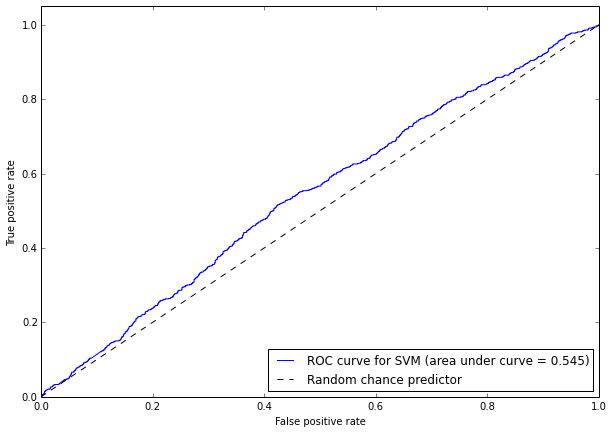

In [92]:
fpr_svm, tpr_svm, thresholds = metrics.roc_curve(ytest, predictions[:,1])
roc_auc_svm = metrics.auc(fpr_svm,tpr_svm)
f, a = plt.subplots()
f.set_size_inches(10,7)

a.plot(fpr_svm, tpr_svm, label='ROC curve for SVM (area under curve = %0.3f)' % roc_auc_svm)
# The 50/50 fpr/tpr line
a.plot([0,1],[0,1],'k--', label='Random chance predictor')
a.set_xlim(0.0,1.0)
a.set_ylim(0.0,1.05)
a.set_xlabel('False positive rate')
a.set_ylabel('True positive rate')
a.legend(loc='lower right')

## One final, total ROC curve

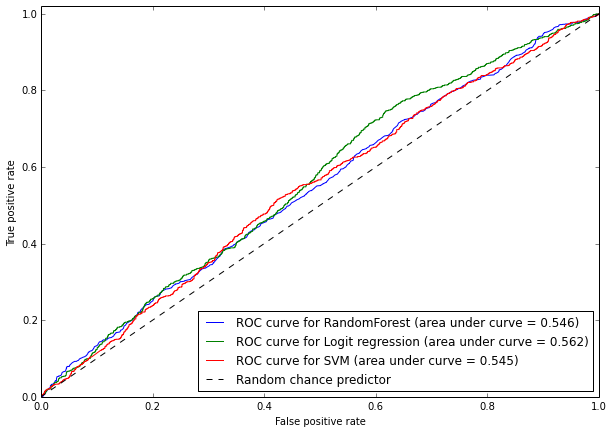

In [95]:
f, a = plt.subplots()
f.set_size_inches(10,7)

a.plot(fpr_rf, tpr_rf, label='ROC curve for RandomForest (area under curve = %0.3f)' % roc_auc_rf)
a.plot(fpr_logit, tpr_logit, label='ROC curve for Logit regression (area under curve = %0.3f)' % roc_auc_logit)
a.plot(fpr_svm, tpr_svm, label='ROC curve for SVM (area under curve = %0.3f)' % roc_auc_svm)
# The 50/50 fpr/tpr line
a.plot([0,1],[0,1],'k--', label='Random chance predictor')
a.set_xlim(0.0,1.0)
a.set_ylim(0.0,1.02)
a.set_xlabel('False positive rate')
a.set_ylabel('True positive rate')
a.legend(loc='lower right')

The Logit regression fit seems to do best, but honestly they are poor predictors.

# Conclusions

OK, I am mostly running the gammut of models I can fit to see how they work and if I can toy with their parameters in a meaningful way. But I think the reason for the bad fits above (again, not particularly better than flipping a coin to decide if each car accident would result in an injury) lies probably in the formula I used.

I am still learning patsy's way of handling formulae (the notation is more set theoretic than algebraic, which confuses the hell out of me for now but will probably become sensical as I work with it more), and the rather 'coarse-grained' formula of adding together categorized variables and just trying to fit them is probably not all that useful for the problem at hand-- something more substantial from the real world, which I have yet to ponder, needs to be included to make this problem tractable to the point where I could point Rome's department of public works to this notebook so that I could say 'Look, the data says address locations/times/conditions on the road that are particular to the discriminant this analysis reveals.' It should also be noted that I also did not particularly modify any of the model fitting parameters, which are legion in each case.

Perhaps some singular value decomposition could better reveal the frame to 'rotate' the data to in order to reveal better discriminants (it was clear from the plots above that none exist at surface level). But doing SVD/PCA on a data set with so many categorical variables doesn't seem particularly warranted.

[Boh.](http://www.culturediscovery.com/tuscany-umbria-cooking-vacation-blog/culture/boh-perfect-italian-words-phrases-translate/) (as I've learned to say while over here)